# Capstone Project - The Battle of Neighborhoods
### 1. Introduction
#### 1.1 Background

#####  We will cluster New York City and the city of Toronto neighbourghoods. In the clusters we will see how similar or dissimilar they are.  For this task we select  New York City borough Queens.  Based on wikipedia information „Queens is the most ethnically diverse urban area in the world It is the most ethnically diverse county in the United States.“.  In Toronto  we will choose borough North York.  Based on wikipedia information „North York is highly multicultural and diverse. In 2016, 56% of North York's residents were not born in Canada, and 60% were classified as belonging to a visible minority.The neighbourhoods of North York are highly diverse, inhabited by people of many different cultures.“
#### 1.2 Problem
##### We have to gather publically available data and merge it with the Foursquare API to explore neighborhoods in New York City and Toronto. We will use the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the k-means clustering algorithm to complete this task.  From Foursquare API  explore endpoint we choose section „food“, because in Canada Foursquare API  return more less data in compare with USA.    
#### 1.3 Interest
##### Similarities or dissimilarities between cities and they neighborhoods could be very useful for companies whose trying to expand they markets. Lets imagine that company has food business in New York borough Queens and wish to explore possibilities in Toronto borough North York.   Based on our report will be possibble to choose neigbourghoods where the same food type industries exist  or not.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
%matplotlib inline

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

### 2. Data section
#### 2.1 New York data

#####  We receive New York neighbourghoods data from   https://cocl.us/new_york_dataset.    Data exist on JSON format so we have to parse data and put into our dataframe. Finally data format will be 

##### Borough	Neighborhood	Latitude	Longitude

#### 2.2 Toronto data 

#####  We receive Toronto neighbourghoods data from web page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.  To gather data we will us    Beautiful Soup  a Python library for pulling data out of HTML .   Because in this page we don't have information about Lattitude and Longitude we download csv file  http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv  and merge this  data to format the same we  used in New York :

##### Borough	Neighborhood	Latitude	Longitude

#### 2.3 Toronto North York  and New York Queens data 
##### Finally we merge Toronto and NewYork  dataframes leaving neigborhood  whoose depends to Toronto North York  and New York Queens  boroughs.  Data format the same:

##### Borough	Neighborhood	Latitude	Longitude   

#### 2.4 Foursquare data 

#####  Use the Foursquare API to explore neighborhoods in New York City and Toronto. We  will use the explore function to get the most common venue categories in each neighborhood .  We add additional parameter in Foursquare Explore endpoint.   Section parameter "food".  So we on request receive information based on food industry.  Finnally managed data  will be formated 

#####  Neighborhood	1st Most Common Venue	2nd Most Common Venue	3rd Most Common Venue ....

#####  With this data  we have to do clustering tasks  

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

In [4]:
!wget -O Geospatial_Coordinates.csv http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv

--2019-06-20 10:47:59--  http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv
Resolving cocl.us (cocl.us)... 169.48.113.201
Connecting to cocl.us (cocl.us)|169.48.113.201|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv [following]
--2019-06-20 10:48:00--  https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv
Connecting to cocl.us (cocl.us)|169.48.113.201|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-06-20 10:48:03--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 185.235.236.197
Connecting to ibm.box.com (ibm.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [followi

In [5]:
# Read Toronto cordinates
df_csv = pd.read_csv('Geospatial_Coordinates.csv')

In [6]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
type(soup)

bs4.BeautifulSoup

In [7]:
# Move all Toronto table wiki to data 
data = []
my_string = ''
table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')

rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    #my_string = ''.join(cols)
    #my_list = my_string.split(",")
    data.append([ele for ele in cols if ele]) # Get rid of empty values

# normalyse data
for data_index in range(len(data)):
    if len(data[data_index]) == 3:
        postcode = data[data_index][0]
        borough = data[data_index][1]
        if borough != 'Not assigned':
            neighbourghood = data[data_index][2]
            if neighbourghood == 'Not assigned':
                neighbourghood = borough
        if data_index>0:
            for partial_index in range(data_index):
                if len(data[partial_index]) == 3:
                    if ((data[partial_index][0] == postcode) and (data[partial_index][1] == borough)):
                        data[partial_index][2] = data[partial_index][2] + ', ' + neighbourghood
                        data[data_index][1] = 'Not assigned' # Mark as 'Not assigned' for future remove

# Create data frame  aliasing as pd and move from data negbourghoods to df

df = pd.DataFrame()
df = pd.DataFrame(columns=['Postal Code','Borough', 'Neighbourghood'])

for data_index in range(len(data)):
    if len(data[data_index]) == 3:
        postcode = data[data_index][0]
        borough = data[data_index][1]
        if borough != 'Not assigned':
            neighbourghood = data[data_index][2]
            if neighbourghood == 'Not assigned':
                neighbourghood = borough
            #  Append a new value to dataframe, remove all values where Foursquare dont have info
            if borough == 'North York':
                if (neighbourghood != 'Bayswater') \
                    and (neighbourghood != 'Bayview Village') \
                    and neighbourghood != 'Brookville' \
                    and neighbourghood != 'CFB Toronto, Downsview East' \
                    and neighbourghood != 'Downsview Central' \
                    and neighbourghood != 'Silver Hills, York Mills' \
                    and neighbourghood != 'Somerville' \
                    and neighbourghood != 'York Mills West' \
                    and neighbourghood != 'Downsview Northwest' \
                    and neighbourghood != 'Emery, Humberlea' \
                    and neighbourghood != 'Victoria Village' \
                    and neighbourghood != 'Newtonbrook, Willowdale': 
                    df = df.append({'Postal Code' : postcode , 'Borough' : borough, 'Neighbourghood' : neighbourghood} , ignore_index=True)


In [8]:
# Add coordinates to Toronto Neighbourghood
neighborhoods = pd.merge(df, df_csv, on='Postal Code',how='left')


Loop through the data and fill the dataframe one row at a time to append New York data to Toronto.

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    #  Append a new value to dataframe, remove all values where Foursquare dont have info 
    if borough =='Queens':
        if (neighborhood_name != 'Bayswater') \
            and (neighborhood_name != 'Bayview Village') \
            and neighborhood_name != 'Brookville' \
            and neighborhood_name != 'CFB Toronto, Downsview East' \
            and neighborhood_name != 'Downsview Central' \
            and neighborhood_name != 'Silver Hills, York Mills' \
            and neighborhood_name != 'Somerville' \
            and neighborhood_name != 'York Mills West' \
            and neighborhood_name != 'Downsview Northwest' \
            and neighborhood_name != 'Emery, Humberlea' \
            and neighborhood_name != 'Neponsit' \
            and neighborhood_name != 'Newtonbrook, Willowdale':         
            neighborhoods = neighborhoods.append({'Postal Code' : 'NYC',
                                                  'Borough': borough,
                                                  'Neighbourghood': neighborhood_name,
                                                  'Latitude': neighborhood_lat,
                                                  'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods

,Postal Code,Borough,Neighbourghood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
2,M3B,North York,Don Mills North,43.745906,-79.352188
3,M6B,North York,Glencairn,43.709577,-79.445073
4,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923
5,M2H,North York,Hillcrest Village,43.803762,-79.363452
6,M3H,North York,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259
7,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
8,M3J,North York,"Northwood Park, York University",43.767980,-79.487262
9,M3L,North York,Downsview West,43.739015,-79.506944


In [10]:
# Define Four square credentials
CLIENT_ID = 'X5SGFPAZDMORJTH5U0KC4HQ5JXEM2WJOSNVVVZ2WUBJI2YCH' # your Foursquare ID
CLIENT_SECRET = 'DLAOFVCFTRY0X5ID0HUMWT0OUPMHXR1S4T2MMJ04JN5HMYGL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
section = 'food'

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            section,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# New York and Toronto venues

nyc_tor_venues = getNearbyVenues(names=neighborhoods['Neighbourghood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Parkwoods
Lawrence Heights, Lawrence Manor
Don Mills North
Glencairn
Flemingdon Park, Don Mills South
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Fairview, Henry Farm, Oriole
Northwood Park, York University
Downsview West
Downsview, North Park, Upwood Park
Humber Summit
Bedford Park, Lawrence Manor East
Willowdale South
Willowdale West
Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Murray Hill
Floral Park
Holliswood
Jamaica Estate

In [14]:
# Size of resulting database
print(nyc_tor_venues.shape)
print('There are {} uniques categories.'.format(len(nyc_tor_venues['Venue Category'].unique())))
nyc_tor_venues.head()


(1753, 7)
There are 95 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,Lac Vien Vietnamese Restaurant,43.721259,-79.468472,Vietnamese Restaurant
3,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,Hot Dog Cart,43.718331,-79.465870,Hot Dog Joint
4,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,Hot dog Stand @Stitches warehouse,43.718646,-79.464019,Hot Dog Joint


In [15]:
# Check how many venues were returned for each neighborhood
grp_nyc_tor_venues = nyc_tor_venues.groupby('Neighborhood').count()
grp_nyc_tor_venues

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,5,5,5,5,5,5
Astoria,84,84,84,84,84,84
Astoria Heights,11,11,11,11,11,11
Auburndale,12,12,12,12,12,12
"Bathurst Manor, Downsview North, Wilson Heights",9,9,9,9,9,9
Bay Terrace,13,13,13,13,13,13
Bayside,55,55,55,55,55,55
"Bedford Park, Lawrence Manor East",21,21,21,21,21,21
Beechhurst,6,6,6,6,6,6


In [16]:
# one hot encoding
nyc_tor_onehot = pd.get_dummies(nyc_tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_tor_onehot['Neighborhood'] = nyc_tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_tor_onehot.columns[-1]] + list(nyc_tor_onehot.columns[:-1])
nyc_tor_onehot = nyc_tor_onehot[fixed_columns]

nyc_tor_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Lawrence Heights, Lawrence Manor",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,"Lawrence Heights, Lawrence Manor",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Lawrence Heights, Lawrence Manor",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
nyc_tor_grouped = nyc_tor_onehot.groupby('Neighborhood').mean().reset_index()
nyc_tor_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Arverne,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Astoria,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,0.023810,0.083333,0.000000,...,0.0,0.000000,0.000000,0.000000,0.011905,0.000000,0.000000,0.011905,0.000000,0.000000
2,Astoria Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Auburndale,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Bathurst Manor, Downsview North, Wilson Heights",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Bay Terrace,0.000000,0.153846,0.000000,0.000000,0.076923,0.000000,0.000000,0.076923,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Bayside,0.000000,0.072727,0.000000,0.000000,0.018182,0.000000,0.018182,0.018182,0.018182,...,0.0,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.018182,0.000000
7,"Bedford Park, Lawrence Manor East",0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000
8,Beechhurst,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Bellaire,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
# Top 5 venues for each neighbourghood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_tor_grouped['Neighborhood']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arverne,Sandwich Place,Pizza Place,Thai Restaurant,Donut Shop,Falafel Restaurant
1,Astoria,Middle Eastern Restaurant,Bakery,Deli / Bodega,Greek Restaurant,Indian Restaurant
2,Astoria Heights,Deli / Bodega,Chinese Restaurant,Italian Restaurant,Burger Joint,Bakery
3,Auburndale,Korean Restaurant,Deli / Bodega,Italian Restaurant,American Restaurant,Diner
4,"Bathurst Manor, Downsview North, Wilson Heights",Pizza Place,Deli / Bodega,Fried Chicken Joint,Chinese Restaurant,Restaurant


In [20]:
# k-means to cluster the neighborhood into 4 clusters.
# set number of clusters
kclusters = 4

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:200] 

array([2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2], dtype=int32)

In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_tor_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourghood')

nyc_tor_merged # check the last columns!

,Postal Code,Borough,Neighbourghood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,BBQ Joint,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Dim Sum Restaurant
1,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,2,Hot Dog Joint,Vietnamese Restaurant,Filipino Restaurant,Dim Sum Restaurant,Diner
2,M3B,North York,Don Mills North,43.745906,-79.352188,2,Restaurant,Caribbean Restaurant,Japanese Restaurant,Café,Wings Joint
3,M6B,North York,Glencairn,43.709577,-79.445073,2,Pizza Place,Asian Restaurant,Sushi Restaurant,Japanese Restaurant,Fast Food Restaurant
4,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923,2,Asian Restaurant,Dim Sum Restaurant,Café,Restaurant,Chinese Restaurant
5,M2H,North York,Hillcrest Village,43.803762,-79.363452,2,Mediterranean Restaurant,Fast Food Restaurant,Wings Joint,Halal Restaurant,Dim Sum Restaurant
6,M3H,North York,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259,2,Pizza Place,Deli / Bodega,Fried Chicken Joint,Chinese Restaurant,Restaurant
7,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,2,Fast Food Restaurant,Asian Restaurant,Restaurant,Food Court,Japanese Restaurant
8,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,2,Pizza Place,Caribbean Restaurant,Eastern European Restaurant,Falafel Restaurant,Wings Joint
9,M3L,North York,Downsview West,43.739015,-79.506944,2,Wings Joint,Filipino Restaurant,Dim Sum Restaurant,Diner,Donut Shop


In [22]:
# Check maybe Foursquare API does not return values on selected venues
nyc_tor_merged[nyc_tor_merged['1st Most Common Venue'].isnull()]

,Postal Code,Borough,Neighbourghood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [23]:
# Calculate Percentage for each city, because number of the neigbourghoods in both cities difiers

def percentage_formula(count_value, borough_value):
    percentage = round (count_value / 15 * 100, 2)
    if borough_value == 'Queens':
        percentage = round (count_value / 77 * 100, 2)
    return (percentage)

# Count how much percents of neigborhoods from Toronto and New York  insist in the same cluster

grouped_data = nyc_tor_merged.groupby(
   ['Cluster Labels', 'Borough']
).agg(
    {      
         'Cluster Labels': 'first',  # get the first date per group
         'Borough': 'first',  # get the first date per group
         'Postal Code': "count"  # get the count of networks
    }
)
df = pd.DataFrame(grouped_data)
df.rename(columns={'Postal Code':'Count'}, inplace=True)
df['Percentage'] = df.apply(lambda row: percentage_formula(row['Count'], row['Borough'] ), axis=1)

df

Count     Borough  Cluster Labels  Percentage
Cluster Labels Borough                                                  
0              Queens          2      Queens               0        2.60
1              North York      2  North York               1       13.33
               Queens         24      Queens               1       31.17
2              North York     13  North York               2       86.67
               Queens         49      Queens               2       63.64
3              Queens          2      Queens               3        2.60

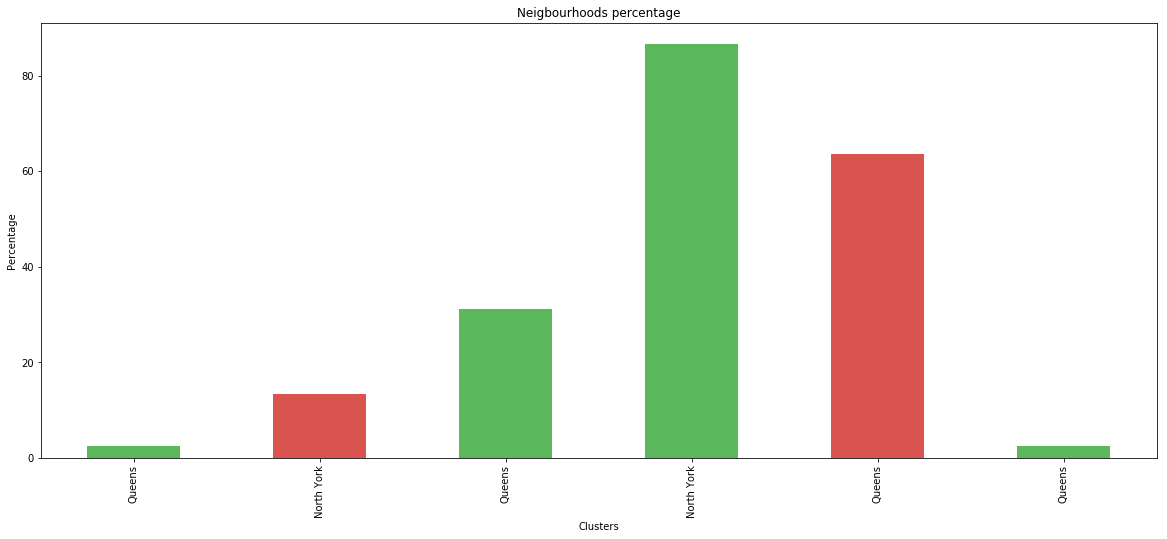

In [24]:
# Plot BAR representation of the percentage data
df.plot(kind='bar', x = 'Borough', y = 'Percentage', stacked=False, figsize=(20, 8), color=['#5cb85c', '#d9534f'], legend=False)

plt.xlabel('Clusters') # add to x-label to the plot
plt.ylabel('Percentage') # add y-label to the plot
plt.title('Neigbourhoods percentage') # add title to the plot

plt.show()

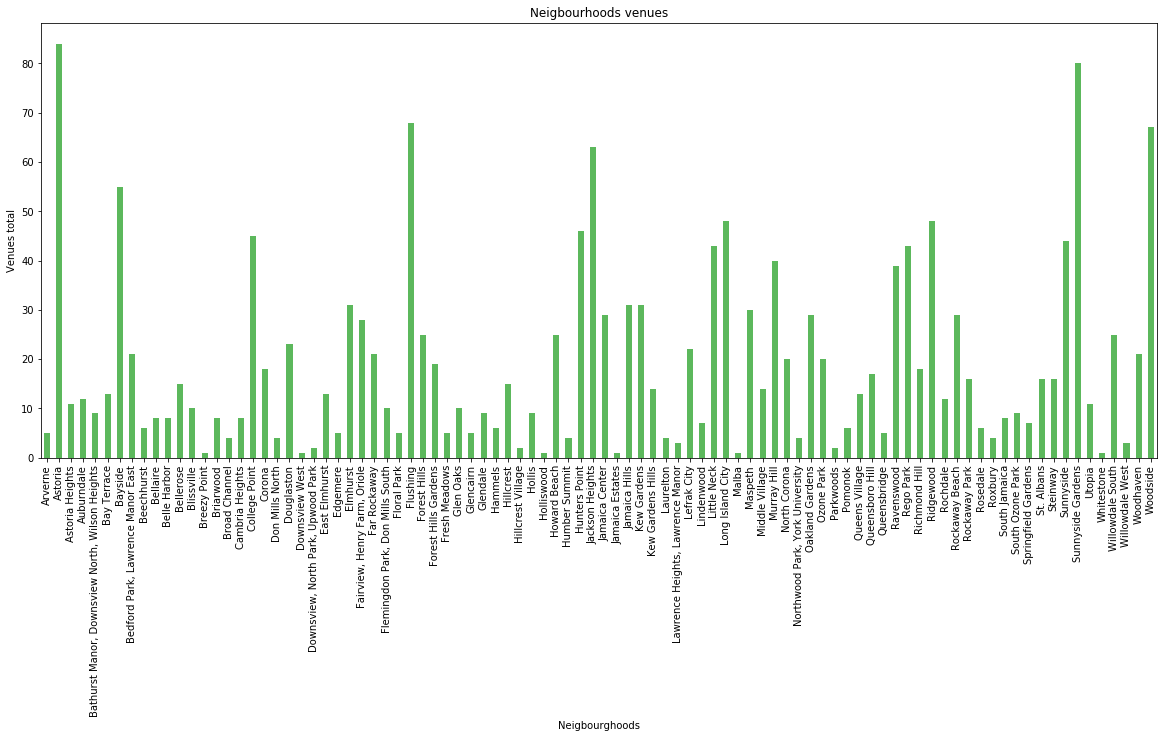

In [25]:
# Plot venues results depending on count

grp_nyc_tor_venues.plot(kind='bar',  y = 'Venue', stacked=False, figsize=(20, 8), color=['#5cb85c'], legend=False)

plt.xlabel('Neigbourghoods') # add to x-label to the plot
plt.ylabel('Venues total') # add y-label to the plot
plt.title('Neigbourhoods venues') # add title to the plot

plt.show()

In [26]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.6524927, -73.7914214158161.


In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_tor_merged['Latitude'], nyc_tor_merged['Longitude'], nyc_tor_merged['Neighbourghood'], nyc_tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster_int = int(round(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster_int-1],
        fill=True,
        fill_color=rainbow[cluster_int-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [28]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, nyc_tor_merged.columns[[1] + list(range(5, nyc_tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
66,Queens,0,Indian Restaurant,Chinese Restaurant,Pizza Place,Wings Joint,Fast Food Restaurant
68,Queens,0,Indian Restaurant,Wings Joint,Filipino Restaurant,Dim Sum Restaurant,Diner


#### Cluster 2

In [29]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, nyc_tor_merged.columns[[1] + list(range(5, nyc_tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,North York,1,Deli / Bodega,Bakery,Filipino Restaurant,Dim Sum Restaurant,Diner
14,North York,1,Pizza Place,Bakery,Wings Joint,Filipino Restaurant,Dim Sum Restaurant
28,Queens,1,Deli / Bodega,Chinese Restaurant,Pizza Place,Bakery,Diner
29,Queens,1,Deli / Bodega,Bakery,Italian Restaurant,Pizza Place,Eastern European Restaurant
30,Queens,1,Deli / Bodega,Pizza Place,Bakery,Chinese Restaurant,Fast Food Restaurant
32,Queens,1,Deli / Bodega,Mexican Restaurant,Pizza Place,Restaurant,Spanish Restaurant
34,Queens,1,Deli / Bodega,Fast Food Restaurant,Donut Shop,Sandwich Place,Food Truck
36,Queens,1,Deli / Bodega,Filipino Restaurant,Dim Sum Restaurant,Diner,Donut Shop
38,Queens,1,Korean Restaurant,Deli / Bodega,Italian Restaurant,American Restaurant,Diner
42,Queens,1,Deli / Bodega,Chinese Restaurant,Pizza Place,Italian Restaurant,Fast Food Restaurant


#### Cluster 3

In [30]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, nyc_tor_merged.columns[[1] + list(range(5, nyc_tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,2,BBQ Joint,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Dim Sum Restaurant
1,North York,2,Hot Dog Joint,Vietnamese Restaurant,Filipino Restaurant,Dim Sum Restaurant,Diner
2,North York,2,Restaurant,Caribbean Restaurant,Japanese Restaurant,Café,Wings Joint
3,North York,2,Pizza Place,Asian Restaurant,Sushi Restaurant,Japanese Restaurant,Fast Food Restaurant
4,North York,2,Asian Restaurant,Dim Sum Restaurant,Café,Restaurant,Chinese Restaurant
5,North York,2,Mediterranean Restaurant,Fast Food Restaurant,Wings Joint,Halal Restaurant,Dim Sum Restaurant
6,North York,2,Pizza Place,Deli / Bodega,Fried Chicken Joint,Chinese Restaurant,Restaurant
7,North York,2,Fast Food Restaurant,Asian Restaurant,Restaurant,Food Court,Japanese Restaurant
8,North York,2,Pizza Place,Caribbean Restaurant,Eastern European Restaurant,Falafel Restaurant,Wings Joint
9,North York,2,Wings Joint,Filipino Restaurant,Dim Sum Restaurant,Diner,Donut Shop


#### Cluster 4

In [31]:
nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, nyc_tor_merged.columns[[1] + list(range(5, nyc_tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
54,Queens,3,Caribbean Restaurant,Restaurant,Chinese Restaurant,Bakery,Wings Joint
73,Queens,3,Caribbean Restaurant,Wings Joint,Cuban Restaurant,Dim Sum Restaurant,Diner
